<h1 style="background:#6A9662; color:#FFF; padding:5px;">Business Analytics with Python</h1>

# <font color='#6A9662'>Marketing Analytics</font>

## Teste A/B - Páginas com avaliações de usuários aumentam as vendas online?

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python usada neste Jupyter Notebook:', python_version())

Versão da Linguagem Python usada neste Jupyter Notebook: 3.7.4


## Como Analisar Testes A/B?

Em geral, realizamos esses 5 passos para analisar um Teste A/B:

1. Configuramos o experimento.

2. Executamos o teste de hipóteses e registramos a taxa de sucesso de cada grupo.

3. Criamos o Plot da distribuição da diferença entre as duas amostras.

4. Calculamos o poder estatístico.

5. Avaliamos como o tamanho das amostras afeta os Testes A/B.

Vamos ao trabalho.

<h2 style="background:#6A9662; color:#FFF; padding:5px;">0. Configurando ambiente</h2>

In [2]:
# Imports
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

# Formatação dos gráficos
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Wecchi Data Science" --iversions

Author: Wecchi Data Science

numpy     : 1.19.2
pandas    : 1.2.1
matplotlib: 3.3.1
scipy     : 1.3.1



<h2 style="background:#6A9662; color:#FFF; padding:5px;">1. Carregando e compreendendo os dados</h2>

>**Dicionário de dados:**
- **id**: número do registro da transação web
- Variante **A**: Mostra o número atual de comentários e avaliações de usuários.
- Variante **B**: Não mostra os comentários de usuários no site (**é o que se pretende responder**).
- **compra**: houve conversão em compra do produto/serviço?
- **data**: data do registro da transação web

In [4]:
# Carrega o dataset
# Usaremos dados fictícios, que representam valores que seriam possíves em um teste real
df_vendas = pd.read_csv("dados/dataset.csv")

In [5]:
# Visualiza 
df_vendas.head()

,id,variante,compra,data
0,0x6f9421,A,False,2019-12-26
1,0x59d442,A,False,2019-08-16
2,0x6db8f8,A,True,2019-03-18
3,0x68245d,A,False,2019-02-13
4,0x28566e,A,False,2019-09-28


In [6]:
# Visualiza 
df_vendas.tail()

,id,variante,compra,data
54995,0x451451,A,False,2019-06-19
54996,0x871d51,A,False,2019-03-22
54997,0x50d163,A,False,2019-02-10
54998,0x3544c4,B,False,2020-01-09
54999,0x983331,A,False,2019-09-05


<h2 style="background:#6A9662; color:#FFF; padding:5px;">2. Análise exploratória</h2>

In [7]:
# Shape dos dados
df_vendas.shape

(55000, 4)

In [8]:
# Tipos de dados - predominantemente tratam-se de dados strings (categóricos)
df_vendas.dtypes

id          object
variante    object
compra        bool
data        object
dtype: object

In [9]:
# Data máxima
df_vendas['data'].max()

'2020-01-30'

In [10]:
# Data mínima
df_vendas['data'].min()

'2019-01-01'

In [11]:
# Checamos por existência de valores nulos
df_vendas.isnull().sum()

id          0
variante    0
compra      0
data        0
dtype: int64

In [12]:
# Checamos se temos IDs duplicados
df_vendas.id.value_counts().count()

55000

In [13]:
# Proporção do resultado de conversão
df_vendas.compra.value_counts()

False    46416
True      8584
Name: compra, dtype: int64

In [14]:
# Proporção das variantes mostradas aos usuários
df_vendas.variante.value_counts()

A    50000
B     5000
Name: variante, dtype: int64

### Calculando probabilidades básicas.

**Variante A é o grupo de controle. Variante B é o grupo de teste ou tratamento.**

In [15]:
# Probabilidade de um usuário visualizar a variante A, considerando o tamanho do teste
round(df_vendas[df_vendas.variante == 'A'].shape[0] / df_vendas.shape[0] * 100,3)

90.909

In [16]:
# Probabilidade de um usuário visualizar a variante B, considerando o tamanho do teste
round(df_vendas[df_vendas.variante == 'B'].shape[0] / df_vendas.shape[0] * 100,3)

9.091

In [17]:
# Probabilidade de um usuário visualizar qualquer variante (100%)
df_vendas.shape[0] / df_vendas.shape[0] * 100

100.0

In [18]:
# Total de compras realizadas (conversões)
df_vendas.compra.sum()

8584

In [19]:
# Total de compras realizadas quando a variante era A
df_vendas[df_vendas.variante == 'A'].compra.sum()

7603

In [20]:
# Total de compras realizadas quando a variante era B
df_vendas[df_vendas.variante == 'B'].compra.sum()

981

In [21]:
# Probabilidade de conversão independente da variante recebida
round(df_vendas.compra.mean() * 100, 3)

15.607

In [22]:
# Dado que um indivíduo estava no grupo de controle, qual é a probabilidade de conversão?
round(df_vendas[df_vendas.variante == 'A'].compra.mean() * 100, 3)

15.206

In [23]:
# Dado que um indivíduo estava no grupo de tratamento, qual é a probabilidade de conversão?
round(df_vendas[df_vendas.variante == 'B'].compra.mean() * 100, 3)

19.62

Como vemos, a probabilidade de um usuário receber a nova página (**sem as avaliações dos usuários**) é de aproximadamente **9.1%** e a probabilidade total de conversão para este grupo é de **19.62%** (maior que o grupo de controle, isto é, 15.21%). <mark>Agora precisamos checar se temos evidências suficientes para dizer que o grupo de tratamento leva a um aumento das conversões</mark>.

<h2 style="background:#6A9662; color:#FFF; padding:5px;">Tarefa 1 - Configurando o Experimento</h2>


**Páginas com Avaliações de Usuários Aumentam as Vendas de Produtos Online?**

- Variante A: Mostra o número atual de comentários e avaliações de usuários
- Variante B: Não mostra os comentários de usuários no site

Observe que, devido ao registro de data e hora associado a cada evento, você pode tecnicamente executar um teste de hipótese continuamente à medida que cada evento é observado. 

Qual o período ideal para coleta de dados? (geralmente 7 dias seriam suficientes)
> No entanto, a questão difícil é saber quando parar assim que uma variante for considerada significativamente melhor do que outra ou isso precisa acontecer de forma consistente por um determinado período de tempo? Quanto tempo até você decidir que nenhuma variante é melhor que a outra? Converse com a área de negócio para definir a melhor abordagem para o teste e apresentaremos algumas dicas durante este trabalho.<br />
Eventualmente coleta contínua pode capturar os eventos de sazionalidades, em contrapartida um período único e estático pode resultar de algum evento externo ao teste, exemplo: coincidiu com o período em que os funcionários recebem o 13 salário.<br />
Essas questões são as partes mais difíceis associadas aos **Testes A/B** e a análise em geral.

Por enquanto, considere que você precisa tomar uma decisão apenas com base nos dados fornecidos. Se você quiser assumir que a variante A é melhor, a menos que a nova variante prove ser definitivamente melhor em uma taxa de erro Tipo I de 5% (nível de significância de 5%), quais deveriam ser suas hipóteses nula e alternativa? 

Você pode definir suas hipóteses em termos de palavras ou em notação como $P_{A}$ e $P_{B}$, que são as probabilidades de conversão para as variantes nova e antiga. (probabilidade é a mediade da incerteza)

- $H_{0}: (P_{B} - P_{A}) = 0$
- $H_{1}: (P_{B} - P_{A}) > 0$

>$H_{0}$ nos diz que a diferença de probabilidade dos dois grupos é igual a zero.<br />
$H_{1}$ nos diz que a diferença de probabilidade dos dois grupos é maior do que zero.

<h3 style="background:#6A9662; color:#FFF; padding:5px;">Tarefa 1 - Pré-processamento dos dados</h3>

Faremos alguns cálculos pesados e para simplificar o processo, iremos filtrar os dados e usar apenas um dos meses. Fique à vontade para usar dados de períodos maiores.

In [24]:
# Função para extrair ano e mês da data (exemplo de datas 2019-12-26)
def extrai_data(x):
    return x[:7]

In [25]:
# Extrai ano e mês da coluna de data
df_vendas['ano_mes'] = df_vendas['data'].apply(extrai_data)

In [26]:
# Visualiza
df_vendas.head()

,id,variante,compra,data,ano_mes
0,0x6f9421,A,False,2019-12-26,2019-12
1,0x59d442,A,False,2019-08-16,2019-08
2,0x6db8f8,A,True,2019-03-18,2019-03
3,0x68245d,A,False,2019-02-13,2019-02
4,0x28566e,A,False,2019-09-28,2019-09


In [27]:
# Vamos trabalhar apenas com os dados de Janeiro/2020 para simplificar o processo didaticamente
df_vendas_2020 = df_vendas[df_vendas['ano_mes'] == '2020-01']

In [28]:
# Visualiza
df_vendas_2020.head()

,id,variante,compra,data,ano_mes
5,0x792f1d,A,False,2020-01-14,2020-01
7,0x724b78,B,False,2020-01-23,2020-01
9,0x684bf9,A,False,2020-01-17,2020-01
10,0x6394dc,A,False,2020-01-06,2020-01
11,0x625f5d,A,False,2020-01-05,2020-01


In [29]:
# shape
df_vendas_2020.shape

(8821, 5)

<h3 style="background:#6A9662; color:#FFF; padding:5px;">Tarefa 1 - Criação do Baseline</h3>

Vamos criar um baseline (linha base) da taxa de conversão antes de executar o teste de hipótese. Assim, saberemos a taxa de conversão base e o aumento desejado em compras que gostaríamos de testar.

* A será o grupo de controle 
* B será o grupo de teste

In [30]:
# Geramos um dataframe
df_ab_data = df_vendas_2020[['variante', 'compra']]
df_ab_data.head()

,variante,compra
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [31]:
# Shape
df_ab_data.shape

(8821, 2)

In [32]:
# Altera o nome das colunas
df_ab_data.columns = ['grupo', 'conversao']

In [33]:
# Visualiza
df_ab_data.head()

,grupo,conversao
5,A,False
7,B,False
9,A,False
10,A,False
11,A,False


In [34]:
# Tabela pivot para o sumário dos dados
df_ab_sumario = df_ab_data.pivot_table(values = 'conversao', index = 'grupo', aggfunc = np.sum)

In [35]:
# Visualiza os dados
df_ab_sumario.head()

,conversao
grupo,
A,587
B,981


In [36]:
# Sumário com total 
df_ab_sumario['total'] = df_ab_data.pivot_table(values = 'conversao', index = 'grupo', aggfunc = lambda x: len(x))

In [37]:
# Sumário com taxa
df_ab_sumario['taxa'] = df_ab_data.pivot_table(values = 'conversao', index = 'grupo')

In [38]:
# Visualiza os dados
df_ab_sumario.head()

,conversao,total,taxa
grupo,,,
A,587,3821,0.153625
B,981,5000,0.196200


In [39]:
# Obtemos os valores da variante A
conversao_A = df_ab_sumario['conversao'][0]
total_A = df_ab_sumario['total'][0]
taxa_A = df_ab_sumario['taxa'][0]

In [40]:
# Imprime os valores de A
print(conversao_A)
print(total_A)
print(taxa_A)

587
3821
0.15362470557445695


In [41]:
# Obtemos os valores da variante B
conversao_B = df_ab_sumario['conversao'][1]
total_B = df_ab_sumario['total'][1]
taxa_B = df_ab_sumario['taxa'][1]

In [42]:
# Imprime os valores de B
print(conversao_B)
print(total_B)
print(taxa_B)

981
5000
0.1962


**Taxa de conversão da linha de base** (Baseline conversion rate).

Igual a $P_{A}$ no contexto de uma distribuição binomial e $P_{A}$ é a probabilidade de sucesso.

In [43]:
# Taxa de conversão da linha de base.
conversao_base = taxa_A
conversao_base

0.15362470557445695

**Efeito mínimo detectável** (Minimum Detectable Effect).

Às vezes referido como nível de significância prática.

In [44]:
# Efeito mínimo detectável
efeito_minimo = taxa_B - taxa_A
efeito_minimo

0.04257529442554306

<h2 style="background:#6A9662; color:#FFF; padding:5px;">Tarefa 2 - Execução do Teste de Hipótese</h2>

Executamos o teste de hipóteses e registramos a taxa de sucesso de cada grupo.

Poder estatístico ou sensibilidade.

Igual a 1 - $\beta$. 

Normalmente 80% é usado para a maioria das análises. É a probabilidade de rejeitar a hipótese nula quando a hipótese nula é de fato falsa.

Parâmetros que usaremos para executar o teste:

1. Alfa $\alpha$ (Nível de significância): normalmente 5% (na prática, nosso nível foi 0.04257529442554306); probabilidade de rejeitar a hipótese nula quando a hipótese nula for verdadeira (erro tipo 1)
2. Beta $\beta$: probabilidade de aceitar a hipótese nula quando a hipótese nula é realmente falsa.

In [45]:
# Parâmetros que usaremos para executar o teste
alfa = 0.05
beta = 0.2

In [46]:
# Tamanho da amostra: estamos definindo um tamanho de 50.000
n = 50000

**Escolha do teste**:
Podemos supor que a distribuição de nosso grupo de controle é binomial porque os dados são uma série de tentativas de Bernoulli, em que cada tentativa tem apenas dois resultados possíveis (semelhante a um cara ou coroa, isto é independentemente de qual variante apresentado ao usuário, durante a sua visita ao site - A ou B - os possíveis resultados serão **comprar** ou **não comprar**).
 
 Para o teste usaremos a função binom() do [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html)

In [47]:
# Teste Binomial (usando padrão de 5% para o nível de significância) ­conversao_base = taxa_A­
teste_binom = scs.binom(n, p = conversao_base)

In [48]:
help(teste_binom)

Help on rv_frozen in module scipy.stats._distn_infrastructure object:

class rv_frozen(builtins.object)
 |  rv_frozen(dist, *args, **kwds)
 |  
 |  # Frozen RV class
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dist, *args, **kwds)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cdf(self, x)
 |  
 |  entropy(self)
 |  
 |  expect(self, func=None, lb=None, ub=None, conditional=False, **kwds)
 |  
 |  interval(self, alpha)
 |  
 |  isf(self, q)
 |  
 |  logcdf(self, x)
 |  
 |  logpdf(self, x)
 |  
 |  logpmf(self, k)
 |  
 |  logsf(self, x)
 |  
 |  mean(self)
 |  
 |  median(self)
 |  
 |  moment(self, n)
 |  
 |  pdf(self, x)
 |  
 |  pmf(self, k)
 |  
 |  ppf(self, q)
 |  
 |  rvs(self, size=None, random_state=None)
 |  
 |  sf(self, x)
 |  
 |  stats(self, moments='mv')
 |  
 |  std(self)
 |  
 |  support(self)
 |  
 |  var(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here

In [49]:
# Teste Binomial com o efeito mínimo (no nosso exemplo 0.04 para o nível de significância)  ­conversao_base = taxa_A­
teste_binom_mde = scs.binom(n, p = conversao_base + efeito_minimo)
# análogo a 
# teste_binom_mde = scs.binom(n, p = taxa_B)

Agora visualizamos a probability mass function (pmf).

<BarContainer object of 50001 artists>

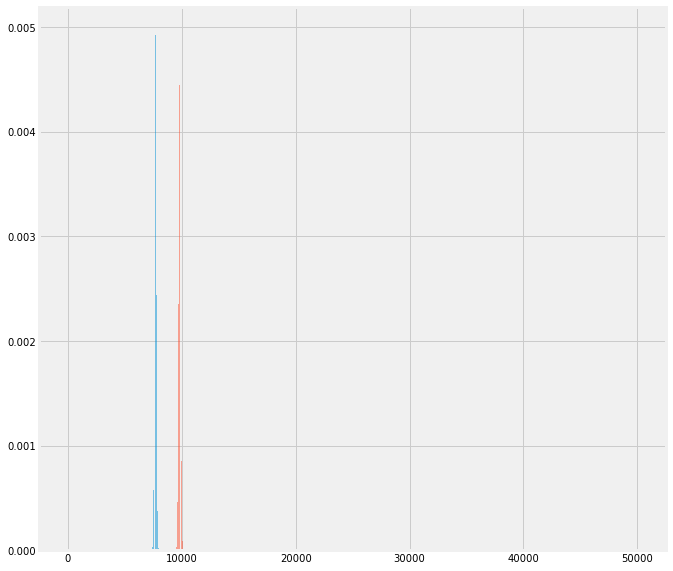

In [50]:
# Plot

# Área de plotagem
fig, ax = plt.subplots(figsize = (10, 10))

# Definimos diversos valores para x
x = np.linspace(0,int(n), int(n) + 1)

# Plotamos os resultados com a pmf e alfa de 0.5 (A - Azul)
ax.bar(x, teste_binom.pmf(x), alpha = 0.5)
# Plotagem (B - Laranja)
ax.bar(x, teste_binom_mde.pmf(x), alpha = 0.5)

* Variante *A* tem maior probabilidade (pico) de ocorrência, porém o número de conversões é <u>menor</u>
* Variante *B* tem menor probabilidade (pico) de ocorrência e o número de conversões é <u>maior</u> (por volta de 10.000) 

<h2 style="background:#6A9662; color:#FFF; padding:5px;">Tarefa 3 - Plot da Distribuição</h2>

Criamos o Plot da distribuição da diferença entre as duas amostras e comparamos os resultados.

Podemos comparar os dois grupos traçando a distribuição do grupo de controle e calculando a probabilidade de obter o resultado de nosso grupo de teste.

Text(0, 0.5, 'Probabilidade')

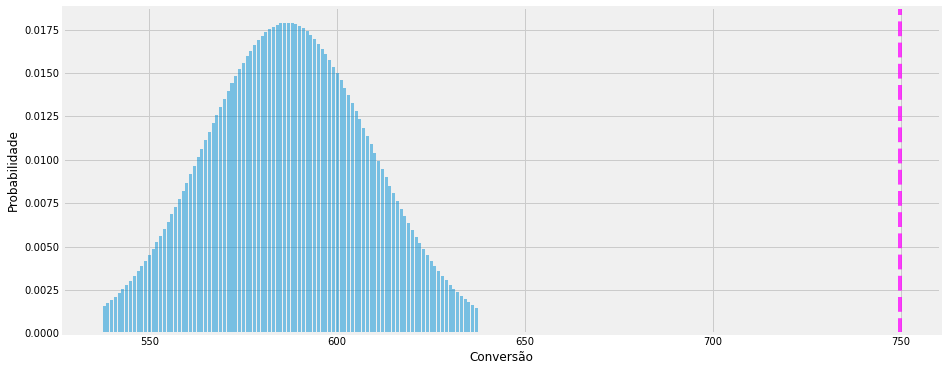

In [51]:
# Plot da distribuição do grupo A (controle)  ­conversao_base = taxa_A­

# Área de plotagem
fig, ax = plt.subplots(figsize = (14,6))

# Teste de A
x = np.linspace(conversao_A - 49, conversao_A + 50, 100)
y = scs.binom(total_A, taxa_A).pmf(x) # pmf é a função de massa de probabilidade para a variável aleatória "x"

# Cria a barra vertical
ax.bar(x, y, alpha = 0.5)
ax.axvline(x = taxa_B * total_A, c = 'magenta', alpha = 0.75, linestyle = '--')

# Labels
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

* a área azul é a distribuição das probabolidades de conversão para A
* porém se usássemos B teríamos a taxa de conversão maior (por volta de 750)

Text(0, 0.5, 'Probabilidade')

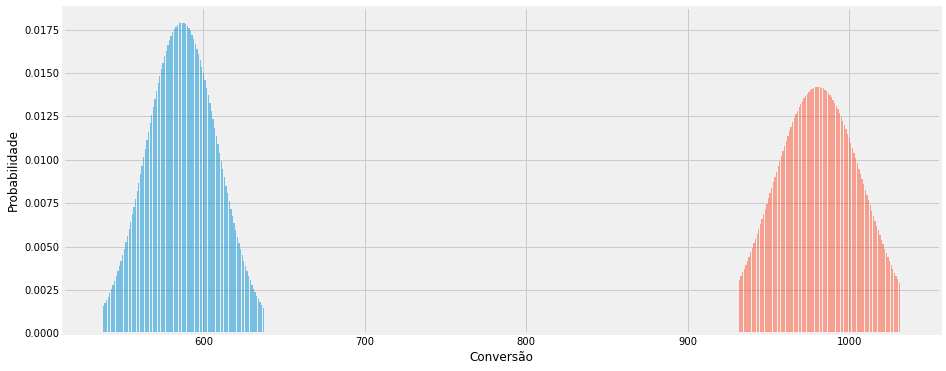

In [52]:
# Plot da distribuição dos 2 grupos

# Área de plotagem 
fig, ax = plt.subplots(figsize = (14,6))

# Gráfico de A
xA = np.linspace(conversao_A - 49, conversao_A + 50, 100)
yA = scs.binom(total_A, taxa_A).pmf(xA)
ax.bar(xA, yA, alpha = 0.5)

# Gráfico de B
xB = np.linspace(conversao_B - 49, conversao_B + 50, 100)
yB = scs.binom(total_B, taxa_B).pmf(xB)
ax.bar(xB, yB, alpha = 0.5)

# Labels
plt.xlabel('Conversão')
plt.ylabel('Probabilidade')

Podemos ver que o grupo de teste (laranja) **converteu mais usuários** do que o grupo de controle (azul). Também podemos ver que o pico dos resultados (probabilidades) do grupo de teste (B) é inferior ao do grupo de controle (A). 

### Mas como interpretamos a diferença no pico da probabilidade? 

Devemos nos concentrar, em vez disso, na taxa de conversão para que tenhamos uma comparação de termos equivalentes. Para calcular isso, precisamos padronizar os dados e comparar a probabilidade de sucesso, p, para cada grupo.

Primeiro, considere a distribuição de Bernoulli para o grupo de controle.
### $$X \sim Bernoulli(p)$$

onde $p$ é a probabilidade de conversão do grupo de controle. De acordo com as propriedades da distribuição de Bernoulli, a média (valor esperado de uma variável aleatória de Bernoulli) e a variância são as seguintes:
### $$E(X) = p$$
### $$V_{ar}(X)=p(1-p)$$
De acordo com o **Teorema Central do Limite**, ao calcular muitas médias amostrais podemos aproximar a média verdadeira da população, $/mu$, da qual os dados para o grupo de controle foram obtidos. A distribuição das médias da amostra, $p$, será normalmente distribuída em torno da média verdadeira com um desvio padrão igual ao erro padrão da média. A equação para isso é dada como:
### $$ \sigma_{\bar{x}} = \frac{s}{\sqrt{n}} = \frac{\sqrt{p(1-p)}}{\sqrt{n}}$$
Portanto, podemos representar ambos os grupos como uma distribuição normal com as seguintes propriedades:
### $$p \sim Normal \left(\mu=p, \sigma=\frac{\sqrt{p(1-p)}}{\sqrt{n}}\right)$$
O mesmo pode ser feito para o grupo de teste. Portanto, teremos duas distribuições normais para $p_{A}$ e $p_{B}$.E com as distribuições normais, nosso trabalho de comparaçãoficará mais fácil.

Antes de continuar, leia o manual em pdf **Distribuição de Bernoulli e o Teorema Central do Limite** no Capítulo 5.

In [53]:
# Ajusta o nome das variáveis

# Probabilidades (taxas de conversão)
p_A = taxa_A
p_B = taxa_B

# Número de conversões
N_A = 3821
N_B = 5000

In [54]:
# Erro padrão (standard error) para a média de ambos os grupos
SE_A = np.sqrt(p_A * (1 - p_A)) / np.sqrt(total_A)
SE_B = np.sqrt(p_B * (1 - p_B)) / np.sqrt(total_B)

In [55]:
# Print
print(SE_A)
print(SE_B)

0.005833423432971666
0.0056161474339621814


Text(0, 0.5, 'PDF - Probability Density Function')

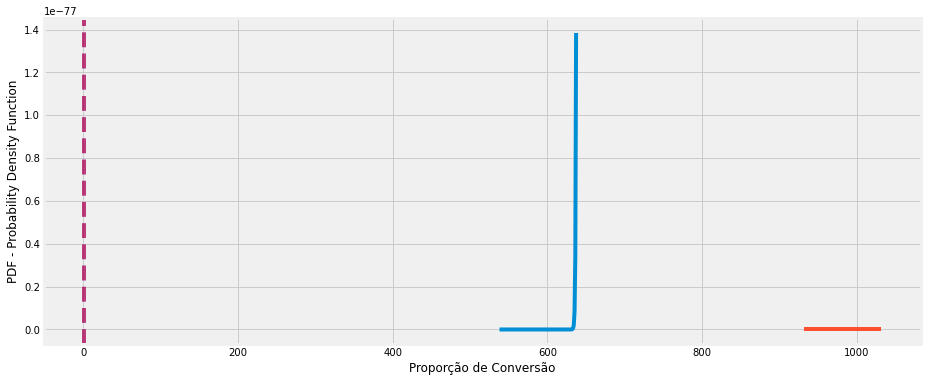

In [56]:
# Plot das distribuições das hipóteses nula e alternativa

# Área de plotagem
fig, ax = plt.subplots(figsize = (14,6))

# Dados para a variável aleatória
x = np.linspace(0, p_B - p_A, 100)

# Distribuição normal de A com a função de densidade de probabilidade (pdf(x)) 
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(xA, yA)
ax.axvline(x = p_A, c = 'blue', alpha = 0.5, linestyle = '--')

# Distribuição normal de B com a função de densidade de probabilidade (pdf(x)) 
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(xB, yB)
ax.axvline(x = p_B, c = 'red', alpha = 0.5, linestyle = '--')

# Labels
plt.xlabel('Proporção de Conversão')
plt.ylabel('PDF - Probability Density Function')

As linhas contínuas representam a taxa de conversão média para cada grupo. A distância entre a linha azul e a linha vermelha é igual à diferença média entre o grupo de controle e teste. 

### Variância da Soma

Lembre-se de que a hipótese nula afirma que a diferença de probabilidade entre os dois grupos é zero. Portanto, a média para essa distribuição normal será zero. A outra propriedade de que precisaremos para a distribuição normal é o desvio padrão ou a variância.

Observação: a variância é o desvio padrão ao quadrado. A variância da diferença dependerá das variâncias da probabilidade para ambos os grupos.

Uma propriedade básica da variância é que a variância da soma de duas variáveis independentes aleatórias é a soma das variâncias:
### $$Var(x+y)=Var(x)+Var(y)$$
### $$Var(x-y)=Var(x)+Var(y)$$
Isso significa que a hipótese nula e alternativa terão a mesma variância que será a soma das variâncias para o grupo de controle e o grupo de teste:
### $$Var(\hat{d})=Var(\hat{p}_{B}-\hat{p}_{A})=Var(\hat{p}_{A})+Var(\hat{p}_{B})=\frac{p_{A}(1-p_{A})}{n_{A}} + \frac{p_{B}(1-p_{B})}{n_{B}}$$
O desvio padrão pode então ser calculado como:
### $$\sigma=\sqrt{Var(\hat{d})}=\sqrt{\frac{p_{A}(1-p_{A})}{n_{A}} + \frac{p_{B}(1-p_{B})}{n_{B}}}$$
Se  colocarmos  esta  equação  em  termos  de  desvio  padrão  para  a  distribuição  de Bernoulli, temos:
### $$\sigma=\sqrt{Var(\hat{d})}=\sqrt{\frac{s_{A}^2}{n_{A}}+\frac{s_{B}^2}{n_{B}}}$$
e obtemos a aproximação de [Satterthwaite](https://pt.qaz.wiki/wiki/Welch%E2%80%93Satterthwaite_equation) para o erro padrão agrupado. Se calcularmos a probabilidade combinada e usarmos a probabilidade combinada para calcular o desvio padrão para ambos os grupos, obtemos:
### $$\sigma=\sqrt{Var(\hat{d})}=\sqrt{\frac{s_{p}^2}{n_{A}}+\frac{s_{p}^2}{n_{B}}}=\sqrt{s_{p}^2\left(\frac{1}{n_{A}}+\frac{1}{n_{B}}\right)}=\sqrt{\hat{p}_{p}(1-\hat{p}_{p})\left(\frac{1}{n_{A}}+\frac{1}{n_{B}}\right)}$$
Onde:
### $$\hat{p}_{p} = \frac{p_{A}N_{A}+p_{B}N_{B}}{N_{A}+N_{B}}$$
Ambas  as  equações  para  o  erro  padrão  combinado  fornecerão  resultados  muito semelhantes.

Com isso, agora temos informações suficientes para construir as distribuições para a hipótese nula e a hipótese alternativa.

<h3 style="background:#6A9662; color:#FFF; padding:5px;">Tarefa 3 - Verificando a Hipótese Nula e a Hipótese Alternativa</h3>

Vamos começar relembrando a definição da hipótese nula e da hipótese alternativa.
- $H_{0}: (P_{B} - P_{A}) = 0$ 
> A hipótese nula é a posição de que a mudança no design feito para o grupo de teste resultaria em **nenhuma mudança na taxa de conversão**.

- $H_{1}: (P_{B} - P_{A}) > 0$
> A hipótese alternativa é a posição oposta de que a mudança no design do grupo de teste resultaria em uma melhoria (ou redução) na taxa de conversão.

A **hipótese nula** ($H_{0}$) será uma distribuição normal com uma média de zero e um desvio padrão igual ao erro padrão agrupado.

A **hipótese alternativa** ($H_{1}$) tem o mesmo desvio padrão que a hipótese nula, mas a média estará localizada na diferença na taxa de conversão, $\hat{d}$. Isso faz sentido porque podemos calcular a diferença nas taxas de conversão diretamente dos dados, mas a distribuição normal representa possíveis valores que nosso experimento poderia ter nos dado.

**Fórmula para o cálculo de z:**
### $$z=\frac{(\bar{x}_{A} - \bar{x}_{B}) - D_{0}}{\sqrt{\sigma_{A}^2ln_{A} + \sigma_{B}^2ln_{B}}} = \frac{(\hat{p}_{A} - \hat{p}_{B}) - 0}{\sqrt{\hat{p}\hat{q}\left(\frac{1}{n_{A}}+\frac{1}{n_{B}}\right)}}$$

In [57]:
# Calculando a probabilidade agrupada
prob_agrupada = (p_A * N_A + p_B * N_B) / (N_A + N_B)

In [58]:
# Calculando z
z = (p_B - p_A) / (prob_agrupada * (1 - prob_agrupada) * (1 / N_A + 1 / N_B))**0.5
z

5.1827257006909795

In [59]:
# Verificamos se z é maior que 1.64 (nível de significância de 0.05)
z > 1.64

True

<h3 style="background:#6A9662; color:#FFF; padding:5px;">Tarefa 3 - Plot da Distribuição de Probabilidade</h3>

Criaremos uma série de funções auxiliares para o plot das distribuições de probabilidade. Leia atentamente todos os comentários.

In [60]:
# Função que retorna a probabilidade agrupada para 2 amostras
def prob_agrupada_func(N_A, N_B, X_A, X_B):
    return (X_A + X_B) / (N_A + N_B)

In [61]:
# Função que retorna o erro padrão (SE) agrupado para 2 amostras
def erro_padrao_agrupado_func(N_A, N_B, X_A, X_B):
    p_hat = prob_agrupada_func(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE

In [62]:
# Retorna o valor z para um determinado nível de significância
def z_val(sig_level = 0.05, two_tailed = True):
    
    # Gera distribuição para o valor z
    z_dist = scs.norm()
    
    # Verifica se devemos checar as duas caudas
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    # Valor de z
    z = z_dist.ppf(area)

    return z

In [63]:
# Calcula o intervalo de confiança
def confidence_interval(sample_mean = 0, sample_std = 1, sample_size = 1, sig_level = 0.05):
    
    # Calcula o valor de z
    z = z_val(sig_level)

    # Limites à esquerda e direita (linhas tracejadas cinza)
    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

In [64]:
# Função que calcula o intervalo de confiança de duas caudas 
def plot_CI(ax, 
            mu, 
            s, 
            sig_level = 0.05, 
            color = 'grey'):

    # Calcula o intervalo de confiança
    left, right = confidence_interval(sample_mean = mu, sample_std = s, sig_level = sig_level)
    
    # Inclui o intervalo no gráfico
    ax.axvline(left, c = color, linestyle = '--', alpha = 0.5)
    ax.axvline(right, c = color, linestyle = '--', alpha = 0.5)

In [65]:
# Função para o plot de uma distribuição normal
def plot_norm_dist(ax, 
                   mu, 
                   std, 
                   with_CI = False, 
                   sig_level = 0.05, 
                   label = None):

    # Gera valores para a variável aleatória x
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    
    # Cria a distribuição normal
    y = scs.norm(mu, std).pdf(x)
    
    # Plot
    ax.plot(x, y, label = label)

    # Se tivermos intervalo de confiança, incluímos no plot
    if with_CI:
        plot_CI(ax, mu, std, sig_level = sig_level)

Função para o plot da distribuição de hipótese nula onde, se não houver mudança real, a distribuição das diferenças entre os grupos de teste e controle será normalmente distribuída.

In [66]:
# Função para o plot da distribuição da H0 - Hipótese Nula
def plot_H0(ax, stderr):
    plot_norm_dist(ax, 0, stderr, label = "H0 - Hipótese Nula")
    plot_CI(ax, mu = 0, s = stderr, sig_level = 0.05)

Função para o plot da distribuição de hipótese alternativa onde, se houver uma mudança real, a distribuição das diferenças entre o teste e os grupos de controle será normalmente distribuída e centralizada em torno de d_hat

In [67]:
# Função para o plot da distribuição da H1 - Hipótese Alternativa
def plot_H1(ax, stderr, d_hat):
    plot_norm_dist(ax, d_hat, stderr, label = "H1 - Hipótese Alternativa")

In [68]:
# Função que preenche entre o limite de significância superior e a distribuição para hipótese alternativa
def show_area(ax, d_hat, stderr, sig_level):

    # Intervalo de confiança
    left, right = confidence_interval(sample_mean = 0, sample_std = stderr, sig_level = sig_level)
    
    # Valores para x
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    
    # H0
    null = ab_dist(stderr, 'controle')
    
    # H1
    alternative = ab_dist(stderr, d_hat, 'teste')

    # Se o tipo da área for igual a power
    # Preenchemos entre o limite de significância superior e a distribuição para hipótese alternativa
    ax.fill_between(x, 0, alternative.pdf(x), color = 'green', alpha = 0.25, where = (x > right))
    ax.text(-3 * stderr, null.pdf(0), 'power = {0:.3f}'.format(1 - alternative.cdf(right)), 
                fontsize = 12, ha = 'right', color = 'k')

In [69]:
# Função que retorna um objeto de distribuição dependendo do tipo de grupo
def ab_dist(stderr, d_hat = 0, group_type = 'controle'):

    # Verifica o tipo de grupo
    if group_type == 'controle':
        sample_mean = 0
    elif group_type == 'teste':
        sample_mean = d_hat

    # Cria uma distribuição normal que depende da média e do desvio padrão
    dist = scs.norm(sample_mean, stderr)
    return dist

In [70]:
# Função que retorna o valor p
def p_val(N_A, N_B, p_A, p_B):
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [71]:
# Função final para o plot da análise do Teste A/B - chama as outras funções
def abplot_func(N_A, 
                N_B, 
                bcr, 
                d_hat, 
                sig_level = 0.05, 
                show_p_value = False,
                show_legend = True):
   
    # Define a área de plotagem
    fig, ax = plt.subplots(figsize = (14, 8))

    # Define parâmetros para encontrar o erro padrão agrupado
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = erro_padrao_agrupado_func(N_A, N_B, X_A, X_B)

    # Plot da distribuição da hipótese nula e alternativa
    plot_H0(ax, stderr)
    plot_H1(ax, stderr, d_hat)

    # Definir a extensão da área do plot
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # Ajustamos o gráfico e preenchemos a área interior
    show_area(ax, d_hat, stderr, sig_level)

    # Mostramos valores-p com base nas distribuições para os dois grupos
    if show_p_value:
        null = ab_dist(stderr, 'controle')
        p_value = p_val(N_A, N_B, bcr, bcr + d_hat)
        ax.text(3 * stderr, null.pdf(0), 'Valor-p = {0:.4f}'.format(p_value), fontsize = 14, ha = 'left')

    # Mostra a legenda
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

Agora que entendemos a derivação do erro padrão combinado, podemos apenas plotar diretamente as hipóteses nula e alternativa para experimentos futuros. Tudo que precisamos é executar a célula abaixo.

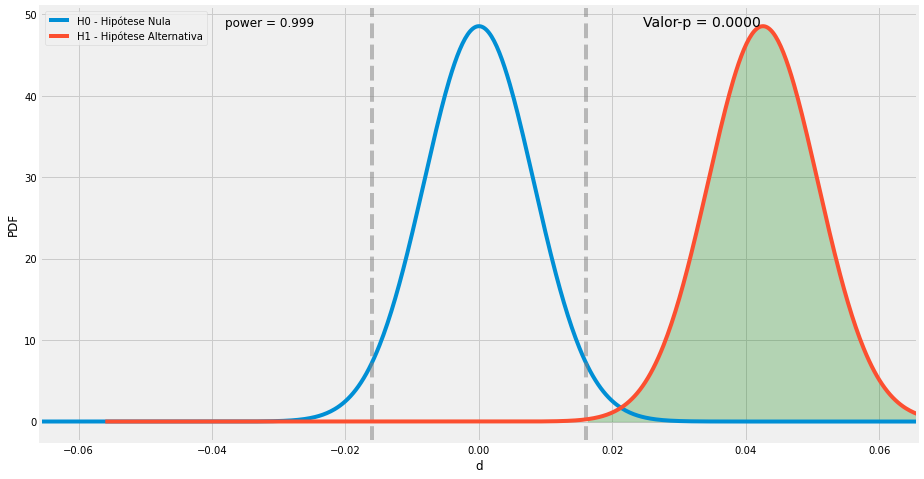

In [72]:
# Definimos os parâmetros e executamos a função
n = N_A + N_B
conversao_base = p_A  
d_hat = p_B - p_A
abplot_func(N_A, N_B, conversao_base, d_hat, show_p_value = True)

Visualmente, o gráfico para as hipóteses nula ($H_{0}$) e alternativa ($H_{1}$) é muito semelhante aos outros gráficos acima. Felizmente, as duas curvas têm formato idêntico, portanto, podemos apenas comparar a distância entre as médias das duas distribuições. Podemos ver que a curva de hipótese alternativa sugere que o grupo de teste tem uma taxa de conversão maior do que o grupo de controle. Este gráfico também pode ser usado para determinar diretamente o poder estatístico.

Alinha laranja nos indica que a média da taxa de conversão de $H_{1}$ é maior que os intervalos de confiança da média de taxa de conversão de $H_{0}$ (linhas tracejadas em cinza), por tanto, isso nos leva a conclusão de que devemos **rejeitar $H_{0}$**, ou seja existe, sim, uma diferença estatística nas conversões de vendas quando não exibimos as avaliações de usuários na página do produto/serviço. E assim **$H_{1}$ é válido** (página web SEM apresentação das avaliações de usuário)

<h2 style="background:#6A9662; color:#FFF; padding:5px;">Tarefa 4 - Calculando o poder Estatístico da avaliação</h2>

Poder Estatístico (power=0.999) e Nível de Significância, em suma é o grau de certeza desse nosso resultado.

É mais fácil definir o poder estatístico e o nível de significância mostrando primeiro como eles são representados no gráfico da hipótese nula e alternativa. Podemos retornar uma visualização do poder estatístico adicionando o parâmetro show_power = True

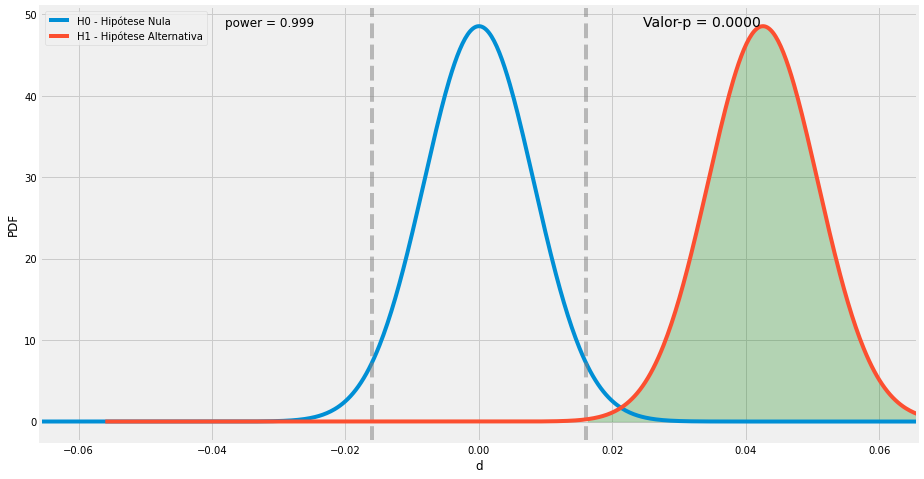

In [73]:
# Executa a função
abplot_func(N_A, N_B, conversao_base, d_hat, show_p_value = True)

A área sombreada em verde representa o poder estatístico e o valor calculado para o poder também é exibido no gráfico. As linhas tracejadas em cinza no gráfico acima representam o intervalo de confiança (95% para o gráfico acima) para a hipótese nula. O poder estatístico é calculado encontrando a área sob a distribuição de hipótese alternativa e fora do intervalo de confiança da hipótese nula.

Depois de executar nosso experimento, obtemos uma taxa de conversão resultante para ambos os grupos. Se calcularmos a diferença entre as taxas de conversão, acabamos com um resultado, a diferença ou o efeito da mudança de design da página web, não mostrando as avaliações de usuários. Nossa tarefa é determinar de qual população esse resultado veio, a hipótese nula ou a hipótese alternativa.

A área sob a curva da hipótese alternativa é igual a 1. Se o design alternativo (sem avaliações) for realmente melhor, o poder é a probabilidade de aceitarmos a hipótese alternativa e rejeitarmos a hipótese nula e é igual à área sombreada em verde (verdadeiro positivo). A área oposta sob a curva alternativa é a probabilidade de não rejeitarmos a hipótese nula e rejeitarmos a hipótese alternativa (falso negativo). Isso é conhecido como beta no teste A/B ou teste de hipótese e é mostrado abaixo.

Se a hipótese nula for verdadeira e realmente não houver diferença entre os grupos de controle e teste, o nível de significância é a probabilidade de rejeitarmos a hipótese nula e aceitarmos a hipótese alternativa (falso positivo). Um falso positivo é quando concluímos erroneamente que o novo design é melhor. Este valor é baixo porque queremos limitar essa probabilidade.

Muitas vezes, um problema será fornecido com um nível de confiança desejado em vez do nível de significância. Um nível de confiança típico de 95% para um teste A / B corresponde a um nível de significância de 0,05.

Os experimentos são normalmente configurados para uma potência mínima desejada de 80%. Se nosso novo design for realmente melhor, queremos que nosso experimento mostre que há pelo menos 80% de probabilidade de que esse seja o caso. Sabemos que, se aumentarmos o tamanho da amostra para cada grupo, diminuiremos a variância combinada para nossa hipótese nula e alternativa. Isso tornará nossas distribuições muito mais estreitas e pode aumentar o poder estatístico. Vamos dar uma olhada em como o tamanho da amostra afetará diretamente nossos resultados.

<h2 style="background:#6A9662; color:#FFF; padding:5px;">Tarefa 5 - Influência do Tamanho da Amostra no Teste A/B</h2>

Nossas curvas para a hipótese nula e alternativa tornaram-se mais estreitas e mais da área sob a curva alternativa está localizada à direita da linha tracejada cinza (isso indica que as médias das duas hipóteses estão mais distantes). O resultado para potência é maior que 0,80 e atende a nossa referência de potência estatística. Agora podemos dizer que nossos **resultados são estatisticamente significativos**.

O próximo problema que devemos encontrar é determinar o **tamanho mínimo da amostra** de que precisaremos para o experimento. E isso é útil saber porque está diretamente relacionado à rapidez com que podemos concluir os experimentos e fornecer resultados estatisticamente significativos para a área de negócio.

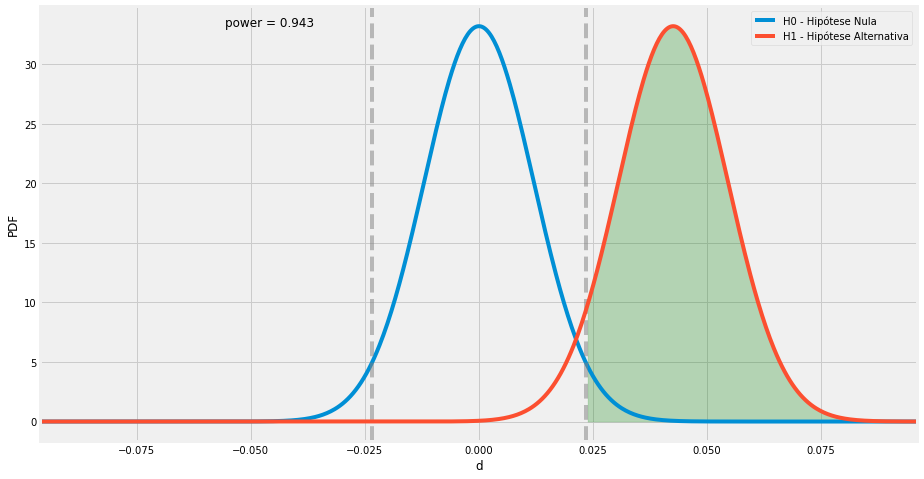

In [74]:
# Executa a função para o tamanho de amostra = 2000
abplot_func(2000, 2000, conversao_base, d_hat)

Temos a taxa de conversão de linha de base e o efeito mínimo detectável, que é a diferença mínima entre o controle e o grupo de teste que a equipe de negócio determinará para valer a pena o investimento de fazer a mudança de design em primeiro lugar.

In [75]:
# Função para incluir o valor z no plot
def zplot(area = 0.95, two_tailed = True, align_right = False):

    # Cria a área de plotagem
    fig = plt.figure(figsize = (12, 6))
    ax = fig.subplots()
    
    # Cria a distribuição normal
    norm = scs.norm()
    
    # Cria os pontos de dados para o plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # Código para preencher áreas para testes bidirecionais
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color = 'grey', linestyle = '--')
        ax.vlines(left, 0, norm.pdf(left), color = 'grey', linestyle = '--')

        ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = (x > left) & (x < right))
        
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), 
                 fontsize = 12, 
                 rotation = 90, 
                 va = "bottom", 
                 ha = "right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right), 
                 fontsize = 12, 
                 rotation = 90, 
                 va = "bottom", 
                 ha = "left")
    
    # Para testes de uma cauda
    else:
        # Alinhamento à direita
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color = 'grey', linestyle = '--')
            ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), 
                     fontsize = 12, 
                     rotation = 90, 
                     va = "bottom", 
                     ha = "right")
        
        # Alinhamento à esquerda
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color = 'grey', linestyle = '--')
            ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right), 
                     fontsize = 12, 
                     rotation = 90, 
                     va = "bottom", 
                     ha = "left")

    # Incluímos texto no plot
    plt.text(0, 0.1, "Área Sombreada = {0:.3f}".format(area), fontsize = 12, ha = 'center')
    
    # Labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()

In [76]:
# Print do valor z
print(z)
print(z_val(sig_level = 0.05, two_tailed = False))
print(z > z_val(sig_level = 0.05, two_tailed = False))

5.1827257006909795
1.6448536269514722
True


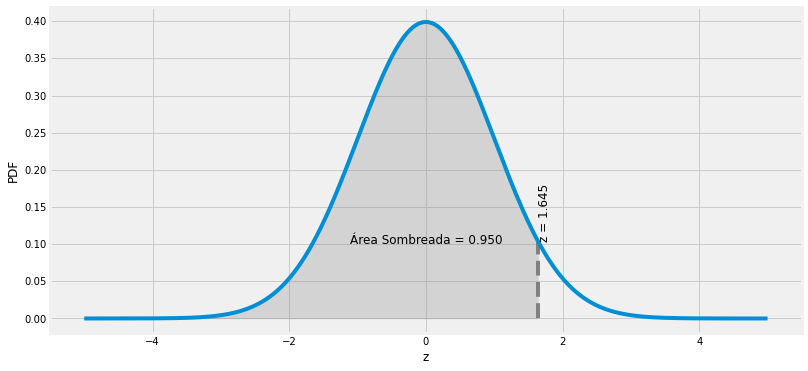

In [77]:
# Plot de z
zplot(area = 0.95, two_tailed = False, align_right = False)

Aqui está o código Python que executa o mesmo cálculo para o tamanho mínimo da amostra:

$$ n_A = k*n_B $$

$$ n_B = (\frac{p_A(1-p_A)}{k}+p_B(1-p_B)) (\frac{Z_{1-\alpha} + Z_{1-\beta}}{p_A-p_B})^{2}$$

$$ n = \frac{2(\bar{p})(1-\bar{p})(Z_{1-\beta}+Z_{1-\alpha})^2}{(p_B-p_A)^2}$$

In [78]:
# Calculamos os valores de z alfa e beta
sig_level = 0.05
beta = 0.2
k = N_A/N_B
standard_norm = scs.norm(0, 1)
Z_beta = standard_norm.ppf(1-beta)
Z_alpha = standard_norm.ppf(1-sig_level)
print(Z_beta)
print(Z_alpha)

0.8416212335729143
1.6448536269514722


Vamos calcular o tamanho mínimo necessário para a amostra.

In [79]:
# Função para encontrar o tamanho mínimo da amostra
def calcula_tamanho_min_amostra(N_A, 
                                N_B, 
                                p_A, 
                                p_B, 
                                power = 0.8, 
                                sig_level = 0.05, 
                                two_sided = False):
   
    k = N_A/N_B
    
    # Distribuição normal para determinar os valores z
    standard_norm = scs.norm(0, 1)

    # Encontramos o valor de z para o poder estatístico
    Z_beta = standard_norm.ppf(power)
    
    # Encontramos z alfa
    if two_sided == True:
        Z_alpha = standard_norm.ppf(1-sig_level/2)
    else:
        Z_alpha = standard_norm.ppf(1-sig_level)

    # Probabilidade agrupada
    pooled_prob = (p_A + p_B) / 2

    # Tamanho mínimo da amostra
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / efeito_minimo**2)    

    return min_N

In [80]:
# Calculamos o tamanho mínimo da amostra com two_sided = True
calcula_tamanho_min_amostra(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = True)

1249.8068972849476

In [81]:
# Calculamos o tamanho mínimo da amostra com two_sided = False
calcula_tamanho_min_amostra(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = False)

984.4720435225323

Agora vamos calcular o tamanho mínimo da amostra considerando nosso baseline.

In [82]:
conversao_base + efeito_minimo

0.1962

In [83]:
# Calcula a probabilidade agrupada
probabilidade_agrupada = (conversao_base + conversao_base + efeito_minimo) / 2
probabilidade_agrupada

0.1749123527872285

In [84]:
# Soma de z alfa e beta
Z_beta + Z_alpha

2.4864748605243863

In [85]:
# Tamanho mínimo da amostra para o baseline
min_N = (2 * probabilidade_agrupada * (1 - probabilidade_agrupada) * (Z_beta + Z_alpha)**2 / efeito_minimo**2)
min_N

984.4720435225323

Poder estatístico para o baseline, isto é para 985 registros na amostra.

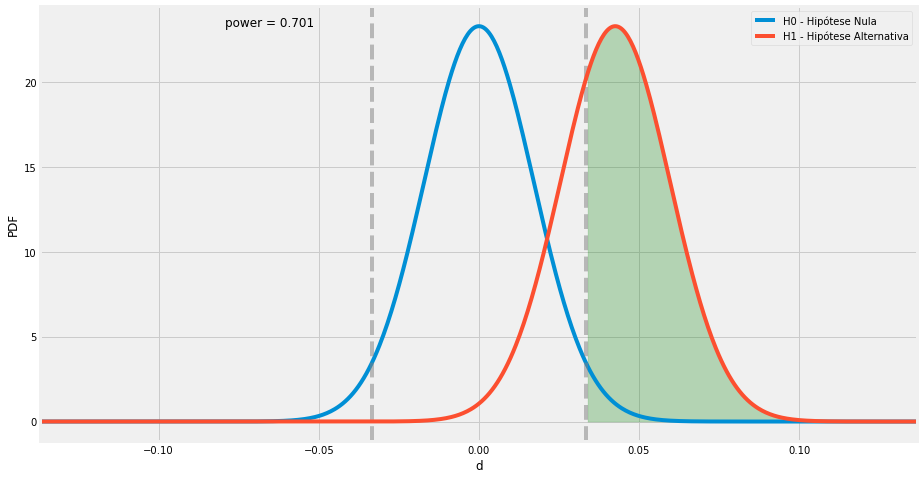

In [86]:
# Executa a função para 985 amostras
abplot_func(N_A = 985, 
            N_B = 985, 
            bcr = p_A, 
            d_hat = p_B - p_A, 
            sig_level = 0.05, 
            show_p_value = False, 
            show_legend = True)

Poder estatístico para o tamanho de amostra calculado, isto é, de 1249 amostras para ambas situações (A e B). Considerando uma potência estatística de 80%.

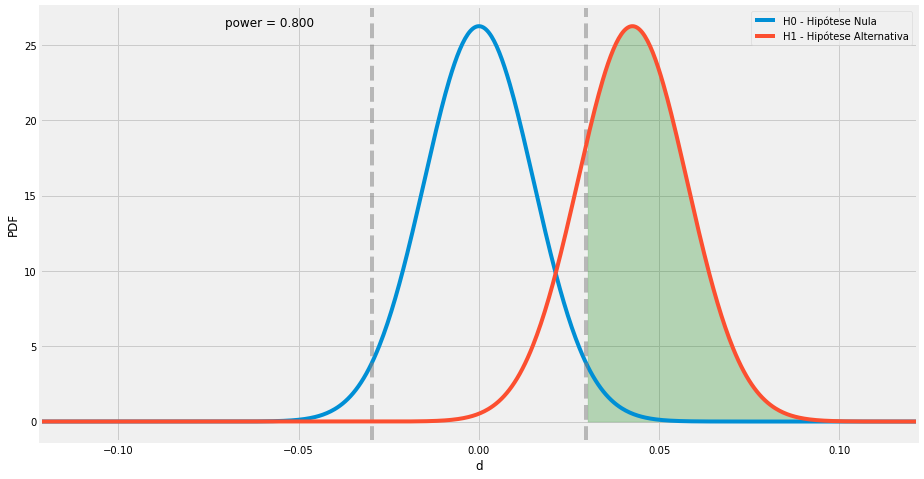

In [87]:
# Executa a função para 1249 amostras
abplot_func(N_A = 1249, 
            N_B = 1249, 
            bcr = p_A, 
            d_hat = p_B - p_A, 
            sig_level = 0.05, 
            show_p_value = False, 
            show_legend = True)

<h2 style="background:#6A9662; color:#FFF; padding:5px;">Conclusão</h2>

Com base em 1249 amostras podemos afirmar que sim, **remover as avaliações de usuários da página aumenta a taxa de conversão**, afirmando isso com um nível de confiança de 80% (poder estatístico).